In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams.update({'font.size': 14})


## 1 Constants etc

In [2]:
df = pd.read_csv("fifty_fifty_full_fetch.csv")
df["Miss Rate"] = df["Number of Misses"] / df["Number of Accesses"]

BAR_WIDTH = 0.15
SINGLE_TRIAL_ERROR = False
HATCHES = {
    'MNIST': '',
    'CIFAR': '...'
}
COLORS = {
    'MNIST': ['lightskyblue', 'royalblue'],
    'CIFAR': ['plum', 'magenta']
}
NUMBERS = ['First', 'Second']
SET_NAMES = {
    'MNIST': 'MNIST',
    'CIFAR': 'CIFAR-10'
}

## 2 Aggregate the Data Frame

In [3]:
agg = df.groupby([  
    'Number of Accesses', 
    'Fetch Size', 
    'Cache Size', 
    'Minimum Queue Size',
    'Epoch']).agg({
        'Data Loading Time (s)': [np.mean, np.std],
        'Number of Misses': [np.mean, np.std],
        'Miss Rate': [np.mean, np.std],
        'Epoch Run Time (s)': [np.mean],
        'Number of Accesses': ['count']
    }).reset_index()

agg.columns = [
    "Number of Accesses",
    "Fetch Size",
    "Cache Size",
    "Minimum Queue Size",
    "Epoch",
    "Data Loading Mean",
    "Data Loading Error",
    "Miss Mean",
    "Miss Error",
    "Miss Rate Mean",
    "Miss Rate Error",
    "Epoch Run Time (s)",
    "Count"
]

agg["Minimum Queue Ratio"] = round(agg["Minimum Queue Size"] / agg["Cache Size"], 2)
agg["Method"] = "Fifty/Fifty"
agg["Model"] = 'CIFAR'
agg.loc[agg["Number of Accesses"] == 14000, 'Model'] = 'MNIST'
agg.loc[agg["Fetch Size"] == 0, 'Method'] = 'Full Fetch'
agg["Bar ID"] = 'c' + agg["Model"].map(str) + '-q' + agg["Minimum Queue Ratio"].map(str)
agg.to_csv('agg.csv', index=False)

# "remove" error bars from single trial experiments (three nodes)
if not SINGLE_TRIAL_ERROR:
    agg.loc[agg['Count'] == 3, ['Miss Rate Error']] = 0
    agg.loc[agg['Count'] == 3, ['Data Loading Error']] = 0


## 3 Plotting Function

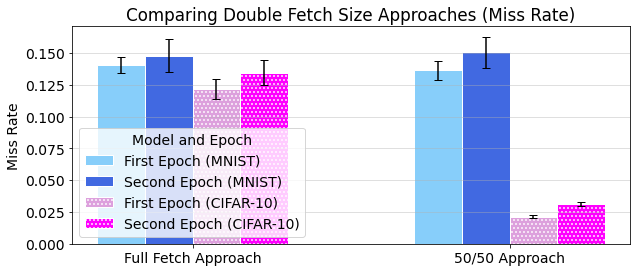

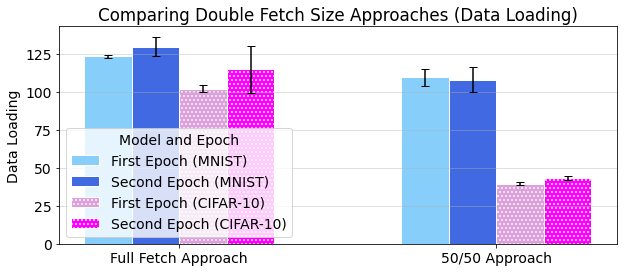

In [4]:
for title, metric in [
    ("Comparing Double Fetch Size Approaches", "Miss Rate"),
    ("Comparing Double Fetch Size Approaches", "Data Loading")
]:
    target = agg

    fig, ax = plt.subplots(figsize=(10,4))

    sub_bars = np.unique(target['Minimum Queue Ratio'])
    bar_clusters = np.unique(target["Cache Size"])

    for dataset_index, dataset_name in enumerate(['MNIST', 'CIFAR']):
        for epoch_index, epoch in enumerate([1, 2]):
            subtarget = target[(target['Model'] == dataset_name) & (target['Epoch'] == epoch)]
            subtarget = subtarget.sort_values(by=[
                'Fetch Size', 
            ], ascending=False)
            ax.bar(
                np.arange(len(subtarget.index)) + BAR_WIDTH * ((2 * dataset_index) + epoch_index), 
                subtarget[f"{metric} Mean"], 
                yerr=subtarget[f"{metric} Error"], 
                align='center', 
                # alpha=0.5, 
                edgecolor='white', 
                ecolor='black',
                color=COLORS[dataset_name][epoch_index],
                capsize=4,
                hatch=HATCHES[dataset_name],
                width=BAR_WIDTH,
                label=f'{NUMBERS[epoch_index]} Epoch ({SET_NAMES[dataset_name]})')

    ax.set_ylabel(f'{metric}')
    ticks = np.arange(2) + 1.5 * BAR_WIDTH
    ax.set_xticks(ticks)
    ax.set_xticklabels(['Full Fetch Approach', '50/50 Approach'])
    ax.set_title(f'{title} ({metric})')
    ax.yaxis.grid(True, alpha=0.5)

    ax.legend(title="Model and Epoch", loc="lower left")

    # plt.savefig(f'{title} ({metric}).png', dpi=300)
    # plt.savefig(f'{title} ({metric}).png', dpi=300, bbox_inches="tight")
    plt.show()